In [1]:
!pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 5.2 MB/s eta 0:00:00


# Finetuned DistilGPT2 for Essays

## Introduction

This kaggle notebook contains a finetuned DistilGPT2 model for generating essays on topics spanning Arts, Science, and Culture. The model has been trained on a dataset of over essays written by human experts, covering a wide range of opinions and knowledge.


## Model Training

The DistilGPT2 model was finetuned for 50 epochs on the dataset. The training and validation losses, as well as the perplexities for a sample of 10 essays, are provided below:

| Epoch | Training Loss | Validation Loss | Perplexities                                                                                                                                                                        | Mean Perplexity |
|-------|----------------|-----------------|---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|-----------------|
| 50    | 2.473200       | 4.569556        | [517.4149169921875, 924.535888671875, 704.73291015625, 465.9677429199219, 577.629150390625, 443.994140625, 770.1861572265625, 683.028076171875, 1017.7510375976562, 880.795166015625] | 698.603519      |

The model achieved a mean perplexity of 698.603519 on the validation set, indicating its ability to generate diverse and high-quality essays on the given topics.


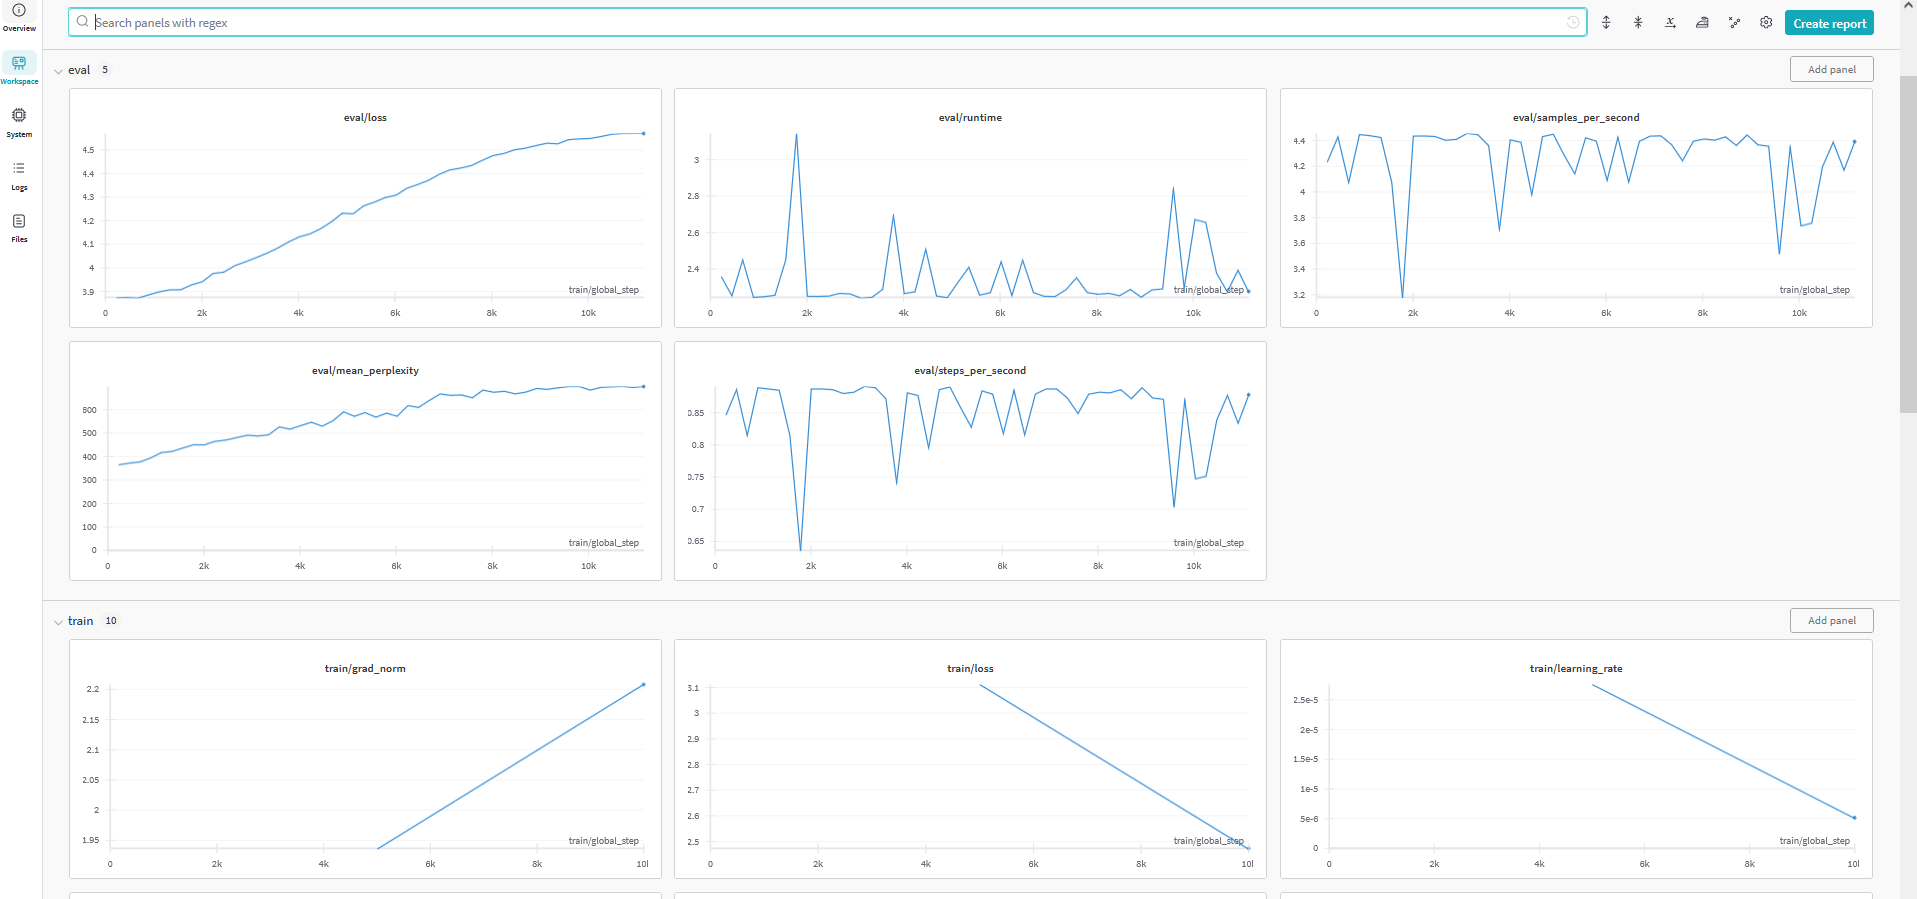

In [31]:
import pandas as pd
from matplotlib import pyplot as plt
import torch
import nltk
import torchvision
from sklearn.feature_extraction.text import TfidfVectorizer
from transformers import AutoModelForCausalLM, AutoTokenizer, AutoConfig
from transformers import Trainer, TrainingArguments
from torch.utils.data import Dataset
import evaluate
import numpy as np

from sklearn.model_selection import train_test_split

# Exploring Data

In [3]:
data = pd.read_csv("/kaggle/input/aeon-essays-dataset/essays.csv")

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2235 entries, 0 to 2234
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   title          2235 non-null   object
 1   description    2235 non-null   object
 2   essay          2235 non-null   object
 3   authors        2235 non-null   object
 4   source_url     2235 non-null   object
 5   thumbnail_url  2235 non-null   object
dtypes: object(6)
memory usage: 104.9+ KB


In [5]:
data.isna().any()

title            False
description      False
essay            False
authors          False
source_url       False
thumbnail_url    False
dtype: bool

In [6]:
data[data.map(type)!=str].any()

title            False
description      False
essay            False
authors          False
source_url       False
thumbnail_url    False
dtype: bool

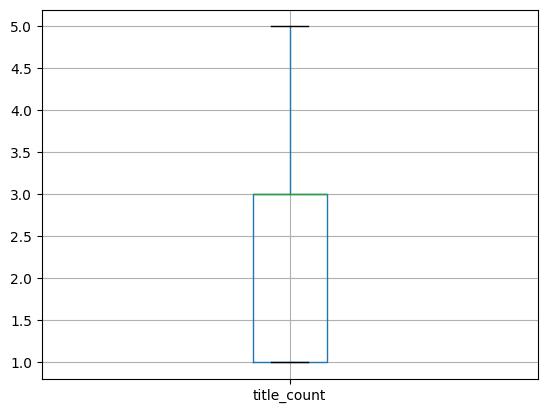

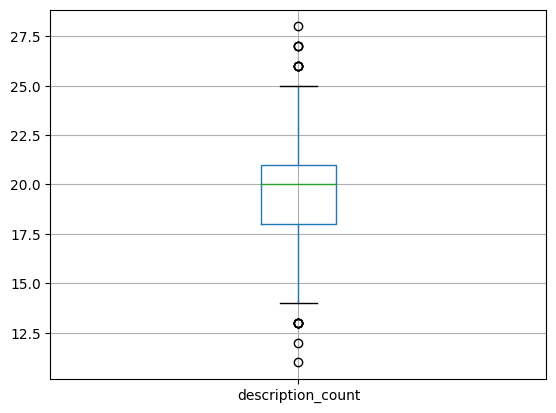

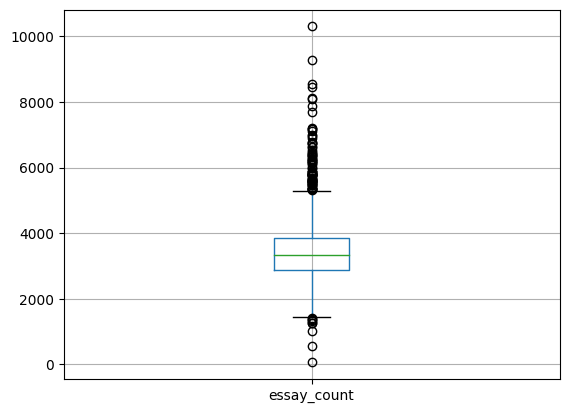

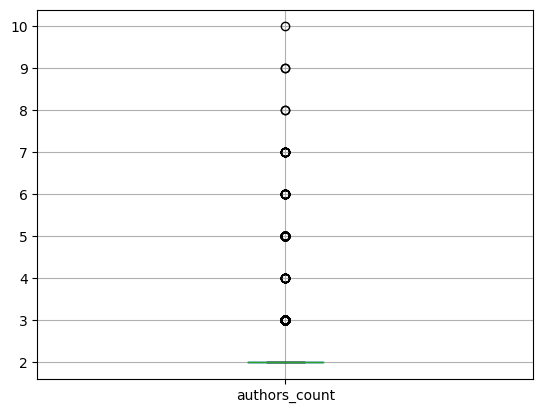

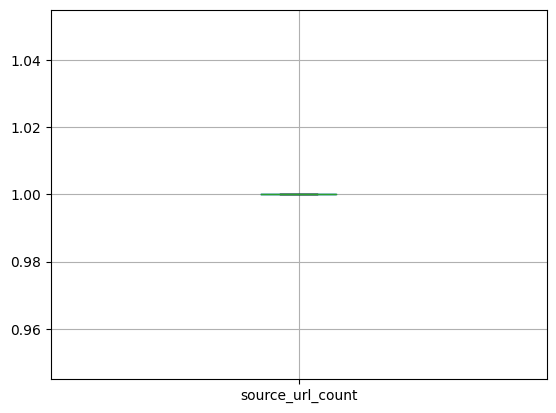

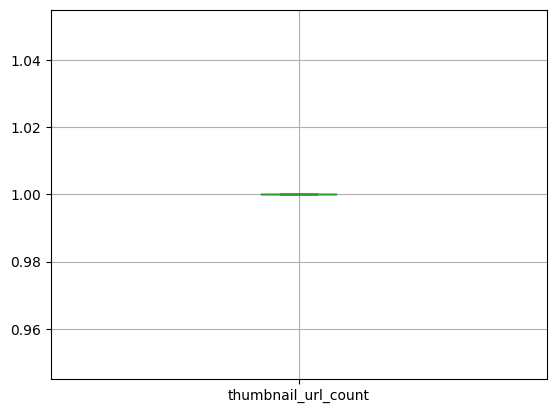

In [7]:


for i in data.columns:
    
    data[f"{i}_count"] = data[i].map(lambda x: len(x.split(" ")))
    data.boxplot([f"{i}_count"])
    plt.show()
    

# Building Training Arguments

In [47]:
# Initializing Training arguments to train the model 
training_args = TrainingArguments(
    # Save model checkpoints in working directory
  output_dir='/kaggle/working/', 
  num_train_epochs=50,  # Training for 50 epochs
    dataloader_pin_memory = False, # To not pin memory, so that cuda long tensors can be used
    logging_steps=5000, # Log values for every 5000 steps
     save_total_limit=3, # Limit on saving checkpoints to 3
    evaluation_strategy="epoch", # evaluate model for every epoch
    save_strategy="epoch", # save for every checkpoint for epoch (only 3 at last)
    load_best_model_at_end=True # load with best model
)

In [48]:
training_args

TrainingArguments(
_n_gpu=1,
accelerator_config={'split_batches': False, 'dispatch_batches': None, 'even_batches': True, 'use_seedable_sampler': True},
adafactor=False,
adam_beta1=0.9,
adam_beta2=0.999,
adam_epsilon=1e-08,
auto_find_batch_size=False,
bf16=False,
bf16_full_eval=False,
data_seed=None,
dataloader_drop_last=False,
dataloader_num_workers=0,
dataloader_persistent_workers=False,
dataloader_pin_memory=False,
dataloader_prefetch_factor=None,
ddp_backend=None,
ddp_broadcast_buffers=None,
ddp_bucket_cap_mb=None,
ddp_find_unused_parameters=None,
ddp_timeout=1800,
debug=[],
deepspeed=None,
disable_tqdm=False,
dispatch_batches=None,
do_eval=True,
do_predict=False,
do_train=False,
eval_accumulation_steps=None,
eval_delay=0,
eval_steps=None,
evaluation_strategy=epoch,
fp16=False,
fp16_backend=auto,
fp16_full_eval=False,
fp16_opt_level=O1,
fsdp=[],
fsdp_config={'min_num_params': 0, 'xla': False, 'xla_fsdp_v2': False, 'xla_fsdp_grad_ckpt': False},
fsdp_min_num_params=0,
fsdp_transformer

In [49]:
device = 'cuda' if torch.cuda.is_available() else 'cpu' # set device to cuda if available

# Exploring Model, Metrics and Tokenizer

In [50]:
# Using Distil GPT2 pretrained model from Hugging face transformers hub, DistilBERT models
model_name = "distilbert/distilgpt2"
# Loading config from the model (using Auto classes for easy and generic retrieval)
config = AutoConfig.from_pretrained("distilbert/distilgpt2")
# Loading Distil GPT2 Tokenizer 
tokenizer = AutoTokenizer.from_pretrained(model_name)
# Loading Pretrained Distil GPT2 Model 
model = AutoModelForCausalLM.from_pretrained(model_name)

In [51]:
model.to(device,non_blocking=True)

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-5): 6 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

In [53]:
# Loading Perplexity Metrics from Hugging Face Evaluate with model ID as GPT2
metrics = evaluate.load("perplexity", module_type = "metric" , model_id = "gpt2")

# Dataset Class

In [54]:
# Custom Dataset class for Essays loading
class EssayCreationDataset(Dataset):
    def __init__(self,essay_dataframe,tokenizer):
        self.essay_dataframe = essay_dataframe
        self.tokenizer= tokenizer
        # set tokenizer padding token as EOS
        self.tokenizer.pad_token = self.tokenizer.eos_token
    
    # Cannot Perform structuring of input, as this increases the input size and low on CUDA memory
    def structure_input(essay_data):
        
        title = essay_data["title"]
        description = essay_data["description"]
        essay = essay_data["essay"]
        
        final_input = f" # {title} ## Description \n <p>{description}</p> ## Essay /n <p>{essay}<p>"
        
        return final_input,essay
    
    def __len__(self):
        # returning the legth of data
        return self.essay_dataframe.shape[0]
    
    def map_tokenizer(self,token_string):
        # tokenize string with truncating to 400 words and if less padding it.
        return self.tokenizer(token_string , padding = "max_length",max_length = 400,truncation= True)
    
    def __getitem__(self,index):
        essay_data = self.essay_dataframe.iloc[index]
        #input_id,label = EssayCreationDataset.structure_input(essay_data)
        # duplicating input strings for next word prediction
        input_id, label = essay_data['essay'] , essay_data['essay'] + ''
        # tokenize inputs
        input_tokenized = self.map_tokenizer(input_id)
        # tokenize labels
        label_tokenized = self.map_tokenizer(label)
        
        
        return {"input_ids": torch.tensor(input_tokenized["input_ids"]).to(device),
                "labels":torch.tensor(label_tokenized["input_ids"]).to(device),
               # "attention_mask" : torch.tensor(input_tokenized["attention_mask"]).to(device)
               }
        
        

In [55]:
# Splitting dataset into train and test
essaydataset = EssayCreationDataset(data[:-10],tokenizer)

essayevaldataset = EssayCreationDataset(data[-10:],tokenizer)

In [56]:
essaydataset[0]

{'input_ids': tensor([ 4366,   640,  2739,   428,  4289,    11,  2130,   481,  4574,   257,
          4936,    11, 15809,  2140,   257,  1204,  2700,   319,   262, 39385,
            13, 12511,   352,    11,   830,   812,    11,   790,  3491,   345,
           460,   766,   379,  1755,   481,  2583, 12661,  1204,    13,   554,
          1342,   621,   257,  1510,   812,    11,   326,  1204,   481, 17373,
           378,   262,  2104, 34822,  6378,    26,   287,  1160,  1510,   812,
           784,   262,  1957,  1448,   286, 27982,    13,   554,   262,  1336,
          1108,   286, 23464,   640,    11,  4138,   286,  2208,   565, 13654,
           286, 27982,   481,   307, 24725,   287,   257,  8097,    12, 11201,
         27225, 16558,   286,  4588,    11,  1247,   445,   319,  3668,    13,
           770,  1839,   447,   247,    83,  2421, 21036, 11887,    13,   383,
          4096,  9391,   423,   587,  7247,  1201,   262,  9507,    82,    13,
          1867,   447,   247,    82,  2

In [57]:
essayevaldataset[0]

{'input_ids': tensor([  818,  2882,   284,   257, 14109,  2008,   287,   543,   339,  4752,
           326,  6298,   583,  1247,   286,  3399,   389,   564,   246, 45841,
           658,    11,   447,   247,   262,  3415,  4787,  4540, 16627,  8431,
           750,   407,  3853,   284, 18282,   465,  6419,    13,   679,   714,
           423,   531,   326,   428,  1271,  1625,   422,   262,  9241,  7820,
          3337,    11,   543,   635,  1043,   326,   749, 12503,   287,   326,
          6298,   583,  1247,   466,  1414, 22235,  5704,    13,   679,   714,
           423,   531,   326,   286,   262,  1248,   583,  1247,   286,  3399,
           508,  1414,  6159, 22235,  4249,  3739,  5704,    11,   517,   621,
          2063,   389, 13830,   290,   517,   621,   257,  2368,   423, 18696,
           739,   720,  1238,    11,   830,    13,   679,   714,   423,  6848,
            11,   517,  2709, 45289,    11,   326,   257,  1178,  6899,  6972,
          1866,   286,   262,  6298,   

In [58]:
# Computing Perplexity on predictions
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    # selecting top predictions
    predictions = np.argmax(logits, axis=-1)
    # compute perplexity over string predictions with model id as parameter
    return metrics.compute( 
        model_id = "distilbert/distilgpt2",
        predictions = [ tokenizer.decode(prediction, skip_special_tokens=True) for prediction in predictions ])

# Model Training

In [59]:
# Initializing training with model, training args, train data and evaluation datasets, along with metrics
trainer = Trainer(model = model, 
                  args = training_args,
                  train_dataset = essaydataset,
                  eval_dataset = essayevaldataset,
                  compute_metrics=compute_metrics)

In [60]:
trainer.train()

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Epoch,Training Loss,Validation Loss,Perplexities,Mean Perplexity
1,No log,3.875726,"[335.80645751953125, 377.47796630859375, 475.9695129394531, 276.7535705566406, 294.2838134765625, 264.73394775390625, 394.9538269042969, 325.2862854003906, 525.1426391601562, 393.2958679199219]",366.370389
2,No log,3.877554,"[356.83929443359375, 425.78094482421875, 495.7661437988281, 287.1143798828125, 270.86737060546875, 256.76934814453125, 391.27044677734375, 345.6097412109375, 498.4945373535156, 408.5922546386719]",373.710446
3,No log,3.874856,"[404.7926940917969, 400.53558349609375, 487.69427490234375, 229.20298767089844, 278.294189453125, 259.6055908203125, 387.93963623046875, 365.1226501464844, 508.79669189453125, 464.8866882324219]",378.687099
4,No log,3.889125,"[386.92559814453125, 444.32073974609375, 480.409912109375, 278.6746520996094, 279.8287353515625, 286.8155212402344, 426.2447204589844, 352.7798767089844, 545.115234375, 475.27459716796875]",395.638959
5,No log,3.901889,"[426.7615051269531, 474.9723815917969, 516.2012329101562, 285.6946105957031, 314.9617919921875, 305.4250793457031, 411.5309143066406, 412.8928527832031, 537.16943359375, 498.3945007324219]",418.400430
6,No log,3.910531,"[421.5846862792969, 457.750244140625, 521.7881469726562, 293.4595642089844, 283.9613037109375, 287.46807861328125, 451.5904846191406, 458.28509521484375, 608.7252197265625, 449.19140625]",423.380423
7,No log,3.910905,"[459.6704406738281, 471.1756591796875, 508.8789367675781, 278.22161865234375, 305.4996337890625, 335.0756530761719, 449.5406494140625, 402.190673828125, 618.786376953125, 547.521240234375]",437.656088
8,No log,3.931489,"[432.6178283691406, 494.5645446777344, 518.4781494140625, 289.39727783203125, 317.63031005859375, 327.0579528808594, 491.4974670410156, 445.9523620605469, 667.2817993164062, 530.4569702148438]",451.493466
9,No log,3.944635,"[452.6179504394531, 445.2970275878906, 576.3162841796875, 262.3009033203125, 326.6243591308594, 311.2583923339844, 440.389404296875, 448.5811767578125, 677.4688110351562, 569.9524536132812]",451.080676
10,No log,3.979356,"[479.5843505859375, 542.103759765625, 561.8331298828125, 283.5645751953125, 342.3445739746094, 315.0624694824219, 494.7655334472656, 397.63812255859375, 683.822265625, 559.3626098632812]",466.008139


  0%|          | 0/1 [00:00<?, ?it/s]

Trainer is attempting to log a value of "[335.80645751953125, 377.47796630859375, 475.9695129394531, 276.7535705566406, 294.2838134765625, 264.73394775390625, 394.9538269042969, 325.2862854003906, 525.1426391601562, 393.2958679199219]" of type <class 'list'> for key "eval/perplexities" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Checkpoint destination directory /kaggle/working/checkpoint-223 already exists and is non-empty. Saving will proceed but saved results may be invalid.


  0%|          | 0/1 [00:00<?, ?it/s]

Trainer is attempting to log a value of "[356.83929443359375, 425.78094482421875, 495.7661437988281, 287.1143798828125, 270.86737060546875, 256.76934814453125, 391.27044677734375, 345.6097412109375, 498.4945373535156, 408.5922546386719]" of type <class 'list'> for key "eval/perplexities" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


  0%|          | 0/1 [00:00<?, ?it/s]

Trainer is attempting to log a value of "[404.7926940917969, 400.53558349609375, 487.69427490234375, 229.20298767089844, 278.294189453125, 259.6055908203125, 387.93963623046875, 365.1226501464844, 508.79669189453125, 464.8866882324219]" of type <class 'list'> for key "eval/perplexities" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


  0%|          | 0/1 [00:00<?, ?it/s]

Trainer is attempting to log a value of "[386.92559814453125, 444.32073974609375, 480.409912109375, 278.6746520996094, 279.8287353515625, 286.8155212402344, 426.2447204589844, 352.7798767089844, 545.115234375, 475.27459716796875]" of type <class 'list'> for key "eval/perplexities" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


  0%|          | 0/1 [00:00<?, ?it/s]

Trainer is attempting to log a value of "[426.7615051269531, 474.9723815917969, 516.2012329101562, 285.6946105957031, 314.9617919921875, 305.4250793457031, 411.5309143066406, 412.8928527832031, 537.16943359375, 498.3945007324219]" of type <class 'list'> for key "eval/perplexities" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


  0%|          | 0/1 [00:00<?, ?it/s]

Trainer is attempting to log a value of "[421.5846862792969, 457.750244140625, 521.7881469726562, 293.4595642089844, 283.9613037109375, 287.46807861328125, 451.5904846191406, 458.28509521484375, 608.7252197265625, 449.19140625]" of type <class 'list'> for key "eval/perplexities" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


  0%|          | 0/1 [00:00<?, ?it/s]

Trainer is attempting to log a value of "[459.6704406738281, 471.1756591796875, 508.8789367675781, 278.22161865234375, 305.4996337890625, 335.0756530761719, 449.5406494140625, 402.190673828125, 618.786376953125, 547.521240234375]" of type <class 'list'> for key "eval/perplexities" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


  0%|          | 0/1 [00:00<?, ?it/s]

Trainer is attempting to log a value of "[432.6178283691406, 494.5645446777344, 518.4781494140625, 289.39727783203125, 317.63031005859375, 327.0579528808594, 491.4974670410156, 445.9523620605469, 667.2817993164062, 530.4569702148438]" of type <class 'list'> for key "eval/perplexities" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


  0%|          | 0/1 [00:00<?, ?it/s]

Trainer is attempting to log a value of "[452.6179504394531, 445.2970275878906, 576.3162841796875, 262.3009033203125, 326.6243591308594, 311.2583923339844, 440.389404296875, 448.5811767578125, 677.4688110351562, 569.9524536132812]" of type <class 'list'> for key "eval/perplexities" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


  0%|          | 0/1 [00:00<?, ?it/s]

Trainer is attempting to log a value of "[479.5843505859375, 542.103759765625, 561.8331298828125, 283.5645751953125, 342.3445739746094, 315.0624694824219, 494.7655334472656, 397.63812255859375, 683.822265625, 559.3626098632812]" of type <class 'list'> for key "eval/perplexities" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


  0%|          | 0/1 [00:00<?, ?it/s]

Trainer is attempting to log a value of "[442.65118408203125, 578.3666381835938, 530.2559204101562, 292.97174072265625, 325.9568786621094, 331.6105651855469, 466.1777648925781, 453.5052490234375, 693.37646484375, 597.4756469726562]" of type <class 'list'> for key "eval/perplexities" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


  0%|          | 0/1 [00:00<?, ?it/s]

Trainer is attempting to log a value of "[490.259765625, 590.09716796875, 524.1170043945312, 292.7325134277344, 362.09210205078125, 320.8348388671875, 483.432861328125, 492.00469970703125, 676.3094482421875, 585.2116088867188]" of type <class 'list'> for key "eval/perplexities" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


  0%|          | 0/1 [00:00<?, ?it/s]

Trainer is attempting to log a value of "[434.7430725097656, 579.150390625, 531.6643676757812, 323.02447509765625, 381.5349426269531, 329.8095397949219, 569.4808349609375, 454.2198486328125, 723.43798828125, 591.2815551757812]" of type <class 'list'> for key "eval/perplexities" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


  0%|          | 0/1 [00:00<?, ?it/s]

Trainer is attempting to log a value of "[465.3315734863281, 577.7365112304688, 532.9083251953125, 298.2411193847656, 371.57415771484375, 335.2172546386719, 547.2592163085938, 480.532470703125, 732.7112426757812, 545.9201049804688]" of type <class 'list'> for key "eval/perplexities" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


  0%|          | 0/1 [00:00<?, ?it/s]

Trainer is attempting to log a value of "[508.1759948730469, 588.5740356445312, 494.7876892089844, 310.3844299316406, 357.8840026855469, 349.0634460449219, 574.1718139648438, 489.5400085449219, 730.5029907226562, 533.7366333007812]" of type <class 'list'> for key "eval/perplexities" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


  0%|          | 0/1 [00:00<?, ?it/s]

Trainer is attempting to log a value of "[516.6371459960938, 603.1266479492188, 558.2211303710938, 320.877685546875, 440.86993408203125, 384.0972595214844, 586.449951171875, 441.53643798828125, 805.31201171875, 614.6945190429688]" of type <class 'list'> for key "eval/perplexities" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


  0%|          | 0/1 [00:00<?, ?it/s]

Trainer is attempting to log a value of "[484.16485595703125, 623.9596557617188, 544.3837890625, 327.7882995605469, 432.2279052734375, 325.2957458496094, 587.2503051757812, 500.35589599609375, 768.452392578125, 581.8598022460938]" of type <class 'list'> for key "eval/perplexities" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


  0%|          | 0/1 [00:00<?, ?it/s]

Trainer is attempting to log a value of "[459.6676025390625, 644.7689819335938, 559.6870727539062, 313.52886962890625, 407.5067443847656, 358.4698486328125, 635.401123046875, 511.8723449707031, 728.2614135742188, 708.4982299804688]" of type <class 'list'> for key "eval/perplexities" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


  0%|          | 0/1 [00:00<?, ?it/s]

Trainer is attempting to log a value of "[513.874267578125, 633.9168090820312, 623.620849609375, 317.8645324707031, 417.3320007324219, 351.769287109375, 557.8528442382812, 530.8079223632812, 834.164306640625, 687.1644897460938]" of type <class 'list'> for key "eval/perplexities" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


  0%|          | 0/1 [00:00<?, ?it/s]

Trainer is attempting to log a value of "[518.4563598632812, 616.3810424804688, 584.39404296875, 357.87530517578125, 424.8235778808594, 363.0649719238281, 572.78369140625, 489.98748779296875, 762.8850708007812, 610.8935546875]" of type <class 'list'> for key "eval/perplexities" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


  0%|          | 0/1 [00:00<?, ?it/s]

Trainer is attempting to log a value of "[496.9158630371094, 622.5189208984375, 620.3365478515625, 315.29119873046875, 508.8257751464844, 386.271728515625, 597.5241088867188, 540.0391845703125, 771.0007934570312, 670.990966796875]" of type <class 'list'> for key "eval/perplexities" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


  0%|          | 0/1 [00:00<?, ?it/s]

Trainer is attempting to log a value of "[542.1947631835938, 699.9281616210938, 655.9802856445312, 351.9259948730469, 517.2227783203125, 364.0205078125, 738.9130859375, 537.7424926757812, 836.2189331054688, 665.9006958007812]" of type <class 'list'> for key "eval/perplexities" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


  0%|          | 0/1 [00:00<?, ?it/s]

Trainer is attempting to log a value of "[529.1312255859375, 677.629638671875, 639.4375, 351.9476623535156, 471.0734558105469, 388.02935791015625, 630.8019409179688, 550.748046875, 854.4290771484375, 626.583984375]" of type <class 'list'> for key "eval/perplexities" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


  0%|          | 0/1 [00:00<?, ?it/s]

Trainer is attempting to log a value of "[532.3706665039062, 650.5995483398438, 640.096435546875, 367.4383850097656, 510.7347106933594, 402.79925537109375, 740.1875610351562, 580.5010375976562, 837.0123901367188, 618.90380859375]" of type <class 'list'> for key "eval/perplexities" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


  0%|          | 0/1 [00:00<?, ?it/s]

Trainer is attempting to log a value of "[493.6273193359375, 687.0193481445312, 617.8013305664062, 356.9241943359375, 462.1817321777344, 377.38800048828125, 662.7510375976562, 553.1047973632812, 769.9375, 702.9688720703125]" of type <class 'list'> for key "eval/perplexities" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


  0%|          | 0/1 [00:00<?, ?it/s]

Trainer is attempting to log a value of "[507.7140808105469, 719.7584228515625, 610.5079956054688, 355.23577880859375, 474.7140197753906, 343.5024719238281, 644.6328125, 599.3197631835938, 868.6974487304688, 729.09326171875]" of type <class 'list'> for key "eval/perplexities" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


  0%|          | 0/1 [00:00<?, ?it/s]

Trainer is attempting to log a value of "[532.3777465820312, 701.5357055664062, 574.2848510742188, 366.85614013671875, 481.5206298828125, 389.685546875, 579.2503662109375, 525.9729614257812, 906.0205078125, 667.3333740234375]" of type <class 'list'> for key "eval/perplexities" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


  0%|          | 0/1 [00:00<?, ?it/s]

Trainer is attempting to log a value of "[530.51416015625, 770.9551391601562, 616.0216674804688, 386.1516418457031, 501.05426025390625, 419.87841796875, 735.8825073242188, 594.3335571289062, 911.9882202148438, 708.704345703125]" of type <class 'list'> for key "eval/perplexities" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


  0%|          | 0/1 [00:00<?, ?it/s]

Trainer is attempting to log a value of "[571.1878662109375, 744.3867797851562, 607.4262084960938, 374.7521057128906, 501.3298034667969, 401.453369140625, 706.0652465820312, 600.0166625976562, 898.824951171875, 692.3529052734375]" of type <class 'list'> for key "eval/perplexities" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


  0%|          | 0/1 [00:00<?, ?it/s]

Trainer is attempting to log a value of "[518.4427490234375, 768.5755615234375, 643.536376953125, 434.2029724121094, 553.5997924804688, 401.9341735839844, 738.0169677734375, 627.0206909179688, 923.0927734375, 787.2225341796875]" of type <class 'list'> for key "eval/perplexities" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


  0%|          | 0/1 [00:00<?, ?it/s]

Trainer is attempting to log a value of "[549.1520385742188, 851.6005249023438, 712.2999267578125, 395.8175048828125, 540.697021484375, 451.8854064941406, 723.3524780273438, 630.9887084960938, 1021.4713745117188, 790.5109252929688]" of type <class 'list'> for key "eval/perplexities" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


  0%|          | 0/1 [00:00<?, ?it/s]

Trainer is attempting to log a value of "[512.7852783203125, 785.50439453125, 668.9815063476562, 457.69830322265625, 539.0671997070312, 459.60736083984375, 751.9481201171875, 625.0054321289062, 999.4456787109375, 808.310546875]" of type <class 'list'> for key "eval/perplexities" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


  0%|          | 0/1 [00:00<?, ?it/s]

Trainer is attempting to log a value of "[559.4247436523438, 747.0921020507812, 678.9531860351562, 437.0193786621094, 544.0770874023438, 431.26568603515625, 756.7093505859375, 626.279052734375, 1022.3748168945312, 824.37841796875]" of type <class 'list'> for key "eval/perplexities" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


  0%|          | 0/1 [00:00<?, ?it/s]

Trainer is attempting to log a value of "[549.6817626953125, 811.8685302734375, 639.683349609375, 410.87249755859375, 510.8334045410156, 438.6333923339844, 779.5153198242188, 584.6727294921875, 1027.2081298828125, 754.08349609375]" of type <class 'list'> for key "eval/perplexities" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


  0%|          | 0/1 [00:00<?, ?it/s]

Trainer is attempting to log a value of "[584.2586059570312, 837.6990966796875, 639.265869140625, 431.7611389160156, 558.5822143554688, 446.50067138671875, 781.8605346679688, 649.52392578125, 1031.22900390625, 871.4506225585938]" of type <class 'list'> for key "eval/perplexities" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


  0%|          | 0/1 [00:00<?, ?it/s]

Trainer is attempting to log a value of "[570.093505859375, 876.3085327148438, 637.6167602539062, 410.8495788574219, 565.6197509765625, 431.1340637207031, 784.1497192382812, 635.3842163085938, 1020.8198852539062, 807.7595825195312]" of type <class 'list'> for key "eval/perplexities" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


  0%|          | 0/1 [00:00<?, ?it/s]

Trainer is attempting to log a value of "[524.7376708984375, 897.5795288085938, 604.8717651367188, 421.68621826171875, 562.4842529296875, 447.8833312988281, 743.5353393554688, 641.0125122070312, 1038.24658203125, 899.0667114257812]" of type <class 'list'> for key "eval/perplexities" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


  0%|          | 0/1 [00:00<?, ?it/s]

Trainer is attempting to log a value of "[517.3828125, 849.9619140625, 632.2133178710938, 421.2346496582031, 562.2227783203125, 412.367919921875, 801.9597778320312, 634.914794921875, 955.3936767578125, 884.5533447265625]" of type <class 'list'> for key "eval/perplexities" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


  0%|          | 0/1 [00:00<?, ?it/s]

Trainer is attempting to log a value of "[523.6810913085938, 871.532958984375, 702.7888793945312, 412.113525390625, 559.32421875, 436.3467712402344, 741.5978393554688, 612.4104614257812, 969.3262329101562, 917.5803833007812]" of type <class 'list'> for key "eval/perplexities" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


  0%|          | 0/1 [00:00<?, ?it/s]

Trainer is attempting to log a value of "[533.463623046875, 880.5369262695312, 677.1242065429688, 468.8255920410156, 524.9594116210938, 481.3450012207031, 724.6446533203125, 644.5559692382812, 1083.451416015625, 882.5050048828125]" of type <class 'list'> for key "eval/perplexities" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


  0%|          | 0/1 [00:00<?, ?it/s]

Trainer is attempting to log a value of "[540.8236083984375, 941.376708984375, 641.9276733398438, 446.772216796875, 562.5877685546875, 455.73175048828125, 764.4960327148438, 647.960205078125, 983.826416015625, 877.977783203125]" of type <class 'list'> for key "eval/perplexities" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


  0%|          | 0/1 [00:00<?, ?it/s]

Trainer is attempting to log a value of "[512.2537841796875, 996.9277954101562, 626.796142578125, 407.5407409667969, 572.6943969726562, 439.5016174316406, 776.8684692382812, 660.894775390625, 1015.8809204101562, 920.075927734375]" of type <class 'list'> for key "eval/perplexities" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


  0%|          | 0/1 [00:00<?, ?it/s]

Trainer is attempting to log a value of "[520.623779296875, 898.4200439453125, 635.4287719726562, 451.1359558105469, 590.0744018554688, 448.103759765625, 752.5787353515625, 682.3783569335938, 1070.27294921875, 934.0402221679688]" of type <class 'list'> for key "eval/perplexities" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


  0%|          | 0/1 [00:00<?, ?it/s]

Trainer is attempting to log a value of "[496.5508728027344, 900.9185180664062, 651.6212768554688, 429.4538879394531, 572.0066528320312, 429.689208984375, 786.3671264648438, 686.788818359375, 1078.3935546875, 950.9196166992188]" of type <class 'list'> for key "eval/perplexities" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


  0%|          | 0/1 [00:00<?, ?it/s]

Trainer is attempting to log a value of "[513.7635498046875, 881.8916625976562, 650.1325073242188, 426.90740966796875, 583.7874145507812, 441.8877258300781, 793.0048828125, 660.0620727539062, 992.5838012695312, 886.9329223632812]" of type <class 'list'> for key "eval/perplexities" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


  0%|          | 0/1 [00:00<?, ?it/s]

Trainer is attempting to log a value of "[484.3752136230469, 864.9951171875, 721.4644775390625, 440.7280578613281, 583.1522216796875, 458.59246826171875, 795.0460815429688, 658.3065795898438, 1043.74267578125, 897.8436279296875]" of type <class 'list'> for key "eval/perplexities" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


  0%|          | 0/1 [00:00<?, ?it/s]

Trainer is attempting to log a value of "[521.9780883789062, 891.4306030273438, 694.7803344726562, 465.2270812988281, 585.0350341796875, 454.22308349609375, 784.2135620117188, 672.1557006835938, 1016.0956420898438, 886.1554565429688]" of type <class 'list'> for key "eval/perplexities" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


  0%|          | 0/1 [00:00<?, ?it/s]

Trainer is attempting to log a value of "[523.372802734375, 930.4688720703125, 683.875732421875, 451.5999755859375, 597.7974243164062, 447.0304870605469, 766.9913940429688, 671.3782348632812, 1039.4984130859375, 876.5855712890625]" of type <class 'list'> for key "eval/perplexities" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


  0%|          | 0/1 [00:00<?, ?it/s]

Trainer is attempting to log a value of "[508.9573059082031, 927.446533203125, 672.3489379882812, 473.5368347167969, 568.0377807617188, 454.00933837890625, 733.6597900390625, 695.4989624023438, 1047.673828125, 864.349853515625]" of type <class 'list'> for key "eval/perplexities" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


  0%|          | 0/1 [00:00<?, ?it/s]

Trainer is attempting to log a value of "[517.4149169921875, 924.535888671875, 704.73291015625, 465.9677429199219, 577.629150390625, 443.994140625, 770.1861572265625, 683.028076171875, 1017.7510375976562, 880.795166015625]" of type <class 'list'> for key "eval/perplexities" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


TrainOutput(global_step=11150, training_loss=2.7442044737948432, metrics={'train_runtime': 7962.9818, 'train_samples_per_second': 13.971, 'train_steps_per_second': 1.4, 'total_flos': 1.1355181056e+16, 'train_loss': 2.7442044737948432, 'epoch': 50.0})

# Results

In [76]:
def generateEssay(prompt, max_length = 400, num_beams = 10, early_stopping =True):
    """
    Generates Essay based on the prompt given
    
    prompt[string]: prompt to pass throught the model generator
    
    max_length[int]: Length of output
    
    num_beams[int]: number of agents performing Beam search over next word prediction
    
    early_stopping[boolean]: To stop early on search 
    """
    tokenizer.pad_token = tokenizer.eos_token
    input_ids = tokenizer.encode(prompt, return_tensors="pt").to(device)
    output = model.generate(input_ids, max_length=max_length, num_beams =num_beams,
                        early_stopping = early_stopping , 
                        temperature = 0.3, no_repeat_ngram_size  =2, num_return_sequences =2 )
    print(tokenizer.decode(output[0], skip_special_tokens=True))
    

In [67]:
prompt = "Write a essay on Space"

input_ids = tokenizer.encode(prompt, return_tensors="pt").to(device)

In [68]:
output = model.generate(input_ids, max_length=400, num_beams =10,
                        early_stopping = True , 
                        temperature = 0.3, no_repeat_ngram_size  =2, num_return_sequences =2 )
print(tokenizer.decode(output[0], skip_special_tokens=True))

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Write a essay on Space.com. It’s one of the best-selling books in the history of science fiction, and the first of its kind to be published by a major publisher. The book is a collection of essays, essays and short stories that explore the origins of life on Earth and beyond. In it, the author describes the life of a human being in a way that makes sense to him. ‘I have no idea what it is like to live in space, but I have a feeling that there is something very special about it. I feel like I am living in an alien world, a world that is very different from the Earth I was born in. That is what makes me feel that space is special to me. And I think that, as a scientist, I can be a little bit more human than most people think. But I also think of space as something that has to do with the fact that we are living on the edge of our own world. This is the kind of book that I want to share with you. What is it about? What are your thoughts on space? How do you feel about the book? Let me kno

In [77]:
prompt = "Liberal Arts"

generateEssay(prompt)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Liberal Arts and Sciences of the United States (ASSA) and the American Association for the Advancement of Science (AAAS). The AAS’s mission is to ‘educate the public in the arts, science, engineering, mathematics, computer science and other fields of higher education, including the humanities and social sciences, as well as the sciences and humanities, in a way that is both respectful and respectful to all students, faculty and staff members, and to the general public, who are interested in learning more about themselves and their contributions to society and society in general and in particular. The AAAS is a non-profit organisation that promotes and promotes the advancement of knowledge, knowledge and culture through a variety of educational programmes and programmes. As a member of its mission, ASSA is committed to promoting and promoting the interests and interests of all Americans, regardless of race, sexual orientation, gender identity, religion, age, sex, marital status, disabil